# Train Model

In [ ]:
import json
from utils import TrainWrapper
config = "/home/anubis/memdir/diploma/diff_unlearn/model/config.json"
save = "/home/anubis/memdir/diploma/diff_unlearn/model/model"

with open(config, "r") as fd:
    config = json.load(fd)

trainer = TrainWrapper(model_save=save, **config)
trainer.train()

# Unlearn Model

  0%|          | 0/700 [00:00<?, ?it/s]

Step 0. Avarage of the last 50 loss values: 0.002723
Step 50. Avarage of the last 50 loss values: 0.055810
Step 100. Avarage of the last 50 loss values: 0.026930
Step 150. Avarage of the last 50 loss values: 0.024450
Step 200. Avarage of the last 50 loss values: 0.024212
Step 250. Avarage of the last 50 loss values: 0.024053
Step 300. Avarage of the last 50 loss values: 0.024785
Step 350. Avarage of the last 50 loss values: 0.023537
Step 400. Avarage of the last 50 loss values: 0.023124
Step 450. Avarage of the last 50 loss values: 0.023038
Step 500. Avarage of the last 50 loss values: 0.023579
Step 550. Avarage of the last 50 loss values: 0.024023
Step 600. Avarage of the last 50 loss values: 0.023353
Step 650. Avarage of the last 50 loss values: 0.023932


  0%|          | 0/1000 [00:00<?, ?it/s]

Step 0. Avarage of the last 50 loss values: 0.002678
Step 50. Avarage of the last 50 loss values: 0.055142
Step 100. Avarage of the last 50 loss values: 0.026058
Step 150. Avarage of the last 50 loss values: 0.024950
Step 200. Avarage of the last 50 loss values: 0.024473
Step 250. Avarage of the last 50 loss values: 0.024227
Step 300. Avarage of the last 50 loss values: 0.024290
Step 350. Avarage of the last 50 loss values: 0.023528
Step 400. Avarage of the last 50 loss values: 0.023402
Step 450. Avarage of the last 50 loss values: 0.023975
Step 500. Avarage of the last 50 loss values: 0.023825
Step 550. Avarage of the last 50 loss values: 0.023618
Step 600. Avarage of the last 50 loss values: 0.023611
Step 650. Avarage of the last 50 loss values: 0.024361
Step 700. Avarage of the last 50 loss values: 0.023668
Step 750. Avarage of the last 50 loss values: 0.024256
Step 800. Avarage of the last 50 loss values: 0.023920
Step 850. Avarage of the last 50 loss values: 0.024117
Step 900. Ava

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 0. Avarage of the last 50 loss values: 0.002946
Step 50. Avarage of the last 50 loss values: 0.059596
Step 100. Avarage of the last 50 loss values: 0.026472
Step 150. Avarage of the last 50 loss values: 0.025047
Step 200. Avarage of the last 50 loss values: 0.024480
Step 250. Avarage of the last 50 loss values: 0.024483
Step 300. Avarage of the last 50 loss values: 0.024877
Step 350. Avarage of the last 50 loss values: 0.024078
Step 400. Avarage of the last 50 loss values: 0.024081
Step 450. Avarage of the last 50 loss values: 0.024293
Step 500. Avarage of the last 50 loss values: 0.037959
Step 550. Avarage of the last 50 loss values: 0.027286
Step 600. Avarage of the last 50 loss values: 0.025607
Step 650. Avarage of the last 50 loss values: 0.024799
Step 700. Avarage of the last 50 loss values: 0.025817
Step 750. Avarage of the last 50 loss values: 0.024451
Step 800. Avarage of the last 50 loss values: 0.024475
Step 850. Avarage of the last 50 loss values: 0.024729
Step 900. Ava

  0%|          | 0/700 [00:00<?, ?it/s]

Step 0. Avarage of the last 50 loss values: 0.002808
Step 50. Avarage of the last 50 loss values: 0.058164
Step 100. Avarage of the last 50 loss values: 0.027369
Step 150. Avarage of the last 50 loss values: 0.024585
Step 200. Avarage of the last 50 loss values: 0.025178
Step 250. Avarage of the last 50 loss values: 0.024575
Step 300. Avarage of the last 50 loss values: 0.024598
Step 350. Avarage of the last 50 loss values: 0.024608
Step 400. Avarage of the last 50 loss values: 0.024054
Step 450. Avarage of the last 50 loss values: 0.024379
Step 500. Avarage of the last 50 loss values: 0.024335
Step 550. Avarage of the last 50 loss values: 0.024735
Step 600. Avarage of the last 50 loss values: 0.024397
Step 650. Avarage of the last 50 loss values: 0.024952


  0%|          | 0/500 [00:00<?, ?it/s]

Step 0. Avarage of the last 50 loss values: 0.002625
Step 50. Avarage of the last 50 loss values: 0.055805
Step 100. Avarage of the last 50 loss values: 0.026473
Step 150. Avarage of the last 50 loss values: 0.024017
Step 200. Avarage of the last 50 loss values: 0.024420
Step 250. Avarage of the last 50 loss values: 0.023791
Step 300. Avarage of the last 50 loss values: 0.024475
Step 350. Avarage of the last 50 loss values: 0.024335
Step 400. Avarage of the last 50 loss values: 0.023731
Step 450. Avarage of the last 50 loss values: 0.023329


  0%|          | 0/500 [00:00<?, ?it/s]

Step 0. Avarage of the last 50 loss values: 0.002956
Step 50. Avarage of the last 50 loss values: 0.060199
Step 100. Avarage of the last 50 loss values: 0.030378
Step 150. Avarage of the last 50 loss values: 0.026052
Step 200. Avarage of the last 50 loss values: 0.025568
Step 250. Avarage of the last 50 loss values: 0.024751
Step 300. Avarage of the last 50 loss values: 0.024450
Step 350. Avarage of the last 50 loss values: 0.023920
Step 400. Avarage of the last 50 loss values: 0.024161
Step 450. Avarage of the last 50 loss values: 0.024840


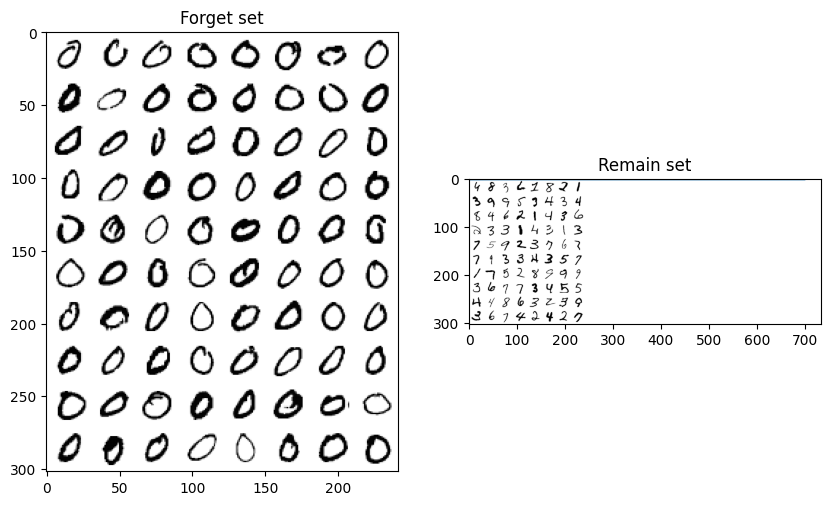

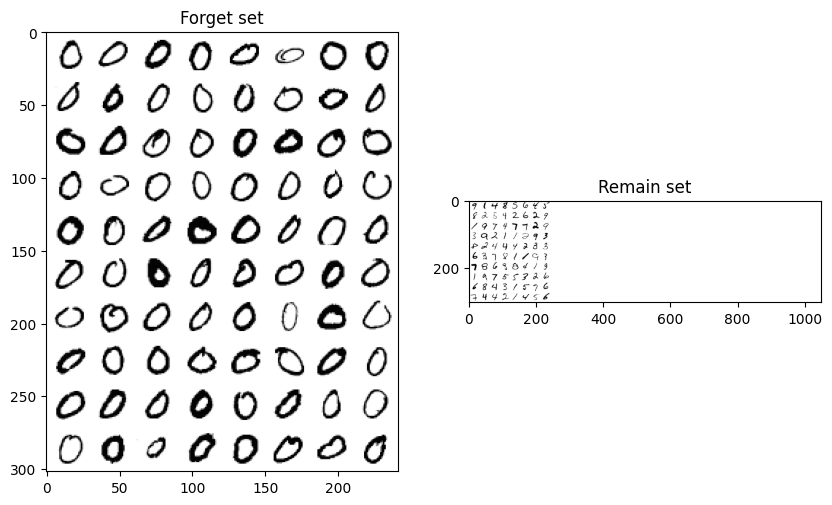

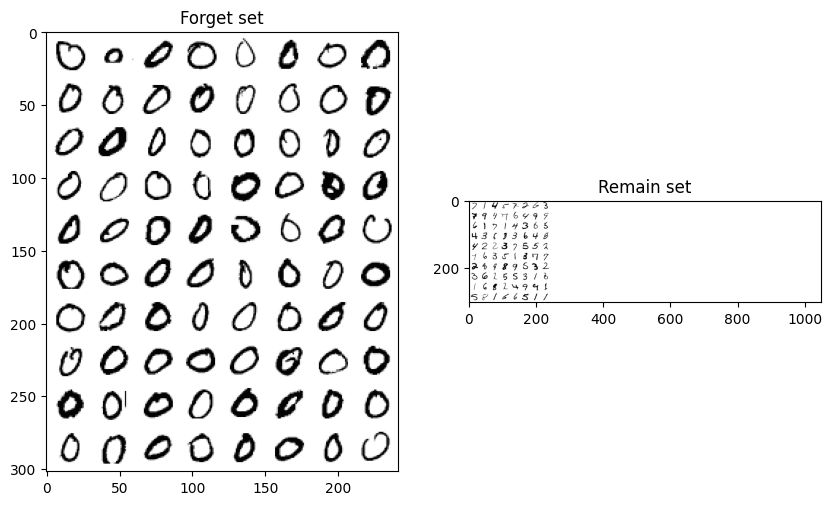

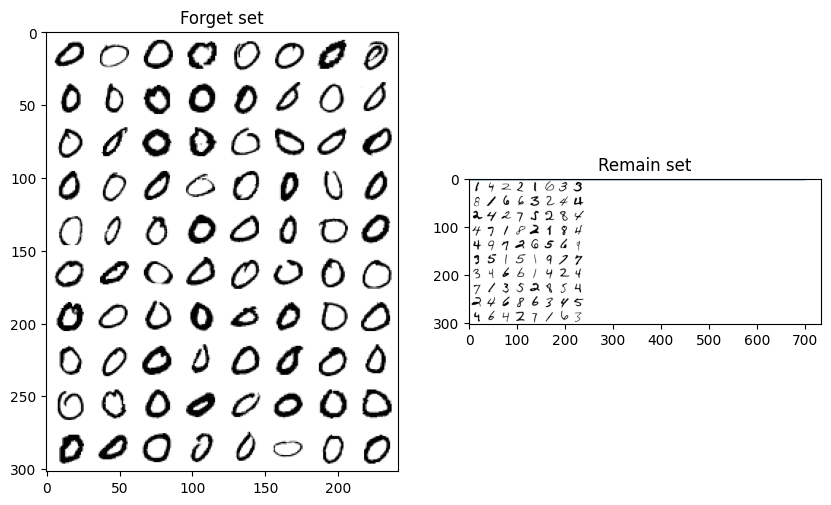

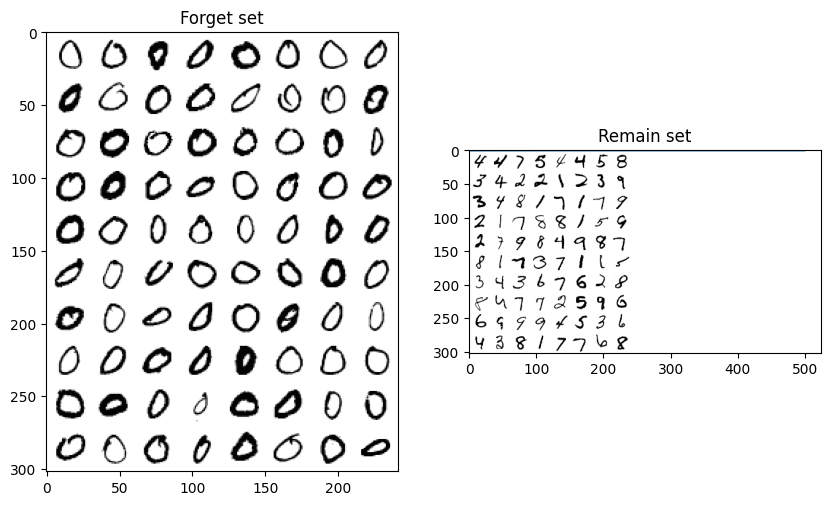

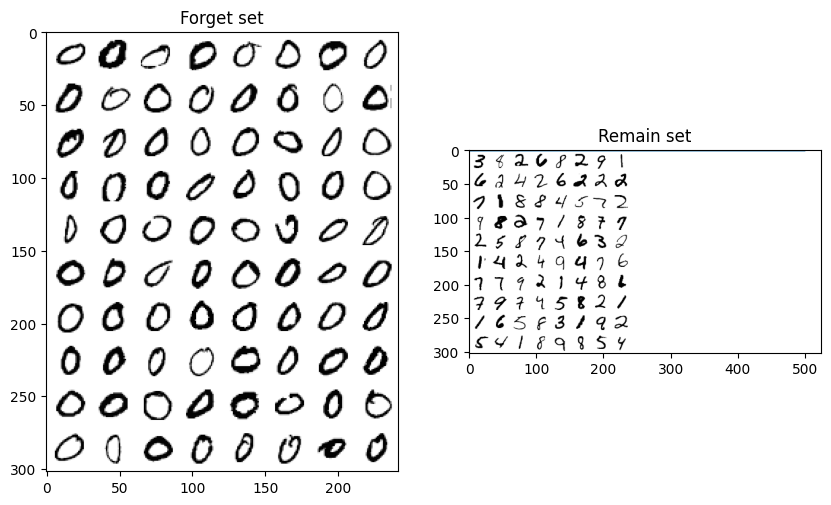

In [1]:
import os
import json
from utils import UnlearnWrapper

conf_path = "/home/anubis/memdir/diploma/diff_unlearn/model_unlearn"

for config in os.listdir(conf_path):
    config = os.path.join(conf_path, config)
    with open(config, "r") as fd:
        conf_dict = json.load(fd)
    
    unlearner = UnlearnWrapper(**conf_dict)
    unlearner()

# Sample

In [3]:
from diffusers import DDPMScheduler
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import torchvision
import torch

from unet import MNIST_Unet

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

DEVICE = "cuda"


In [4]:
model = MNIST_Unet()
model.load_state_dict(torch.load("model/model15.pt"))

<All keys matched successfully>

In [11]:
x = torch.randn(80, 1, 28, 28).to(DEVICE)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(DEVICE)
model.to(DEVICE)
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(x, t, y)  # Again, note that we pass in our labels y

    x = noise_scheduler.step(residual, t, x).prev_sample

0it [00:00, ?it/s]

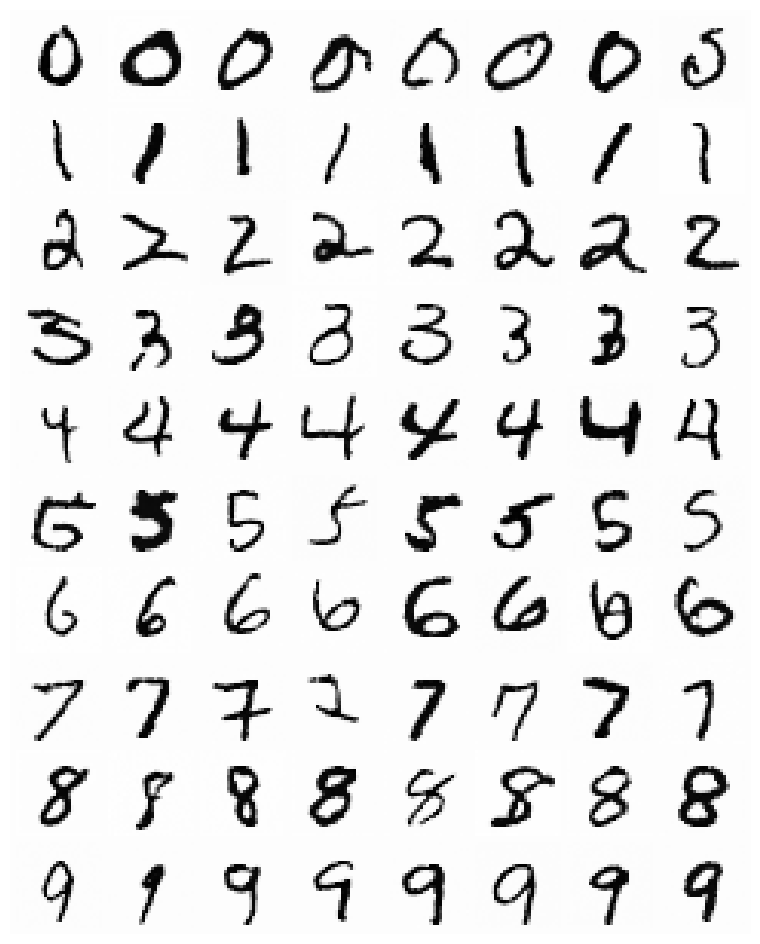

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.axis("off")
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')
plt.savefig("tests/sample.jpg")

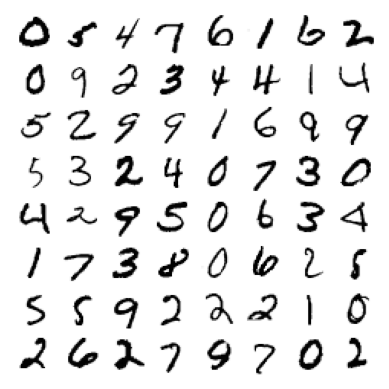

In [1]:
from data import MakeDataLoader

loader_maker = MakeDataLoader(ds_name="mnist", batch_size=64)()